<a href="https://www.kaggle.com/code/dsptlp/conversion-curve-a-b-test?scriptVersionId=171002016" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Conversion Curve for A/B Experiment
- In A/B testing, a conversion curve is a graphical representation that compares the conversion rates of two or more variants (typically referred to as A and B). A conversion curve helps visualize how the conversion rate varies across different levels of engagement or interaction with the tested elements.

## Here's how you can explain the conversion curve comparing the two results:

- X-axis: The x-axis typically represents different levels of engagement or interaction, such as time spent on a website, number of clicks, or any other relevant metric.
- Y-axis: The y-axis represents the conversion rate, which is the proportion of users who perform the desired action (e.g., make a purchase, sign up for a newsletter) out of the total number of users.

- Curves: Each variant (A and B) will have its conversion curve plotted on the graph. These curves represent how the conversion rate changes as the level of engagement varies.

- Variant A: One curve represents the conversion rate for variant A. It might start at a certain level and then either increase, decrease, or remain relatively constant as engagement increases.

- Variant B: Another curve represents the conversion rate for variant B. Similarly, it will show how the conversion rate changes with different levels of engagement.

- Comparison: By comparing the two curves, you can assess which variant performs better at different levels of engagement. The variant with a higher conversion rate curve generally indicates better performance for that level of engagement.

- Intersection points: Points where the curves intersect or cross over each other indicate levels of engagement where the performance of one variant is better than the other. These points are crucial for understanding the effectiveness of each variant across different scenarios.

- Overall performance: You can also assess the overall performance of each variant by comparing the area under the curve. A larger area under the curve typically indicates higher overall conversion rates across all levels of engagement.

- In summary, a conversion curve in A/B testing provides a visual representation of how the conversion rate varies across different levels of engagement for each variant, helping to compare and evaluate the effectiveness of the variants.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator  
import warnings

import statistics
from scipy import stats
from itertools import chain, repeat
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "/kaggle/input/generaldataset/conversionABC.csv"
df = pd.read_csv(data_path, delimiter=',') 
df.head(2)

,IsConversion,ActivationDate,Group,ConversionDate
0,0,2022-01-01,Group_A,NaN
1,0,2022-01-01,Group_A,NaN


In [3]:
# Convert string columns to datetime
df['ActivationDate'] = pd.to_datetime(df['ActivationDate'])
df['ConversionDate'] = pd.to_datetime(df['ConversionDate'])

# Calculate the delta of days between Date2 and Date1
df['DeltaDays'] = (df['ConversionDate'] - df['ActivationDate']).dt.days

df.head(5)

,IsConversion,ActivationDate,Group,ConversionDate,DeltaDays
0,0,2022-01-01,Group_A,NaT,NaN
1,0,2022-01-01,Group_A,NaT,NaN
2,1,2022-01-01,Group_A,2022-01-22,21.0
3,0,2022-01-01,Group_A,NaT,NaN
4,0,2022-01-03,Group_A,NaT,NaN


In [4]:
def create_scurve_result(df):
    row_cnt = 0
    columns = ['X','Conv_Total','IsConversion']
    df_new = pd.DataFrame(columns=columns)
    total_rows = len(df.index)
    
    for i in range (0,60):
        found = df.loc[(df['DeltaDays'] == i)]
        row_cnt = (len(found.index) + row_cnt) 
        
        if total_rows > 0:
            conv_running = (row_cnt / total_rows) 
        else:
            conv_running=0
        
        df_new.loc[i] = [i,conv_running,(len(found.index))]
    
    return df_new

In [5]:
DF1 = df[df['Group']=='Group_A']
DF1_R = create_scurve_result(DF1)
DF1_R = DF1_R.drop(columns=['IsConversion'])
DF1_R['Group'] = 'Group_A'
DF1_R = DF1_R.rename(index=str,columns={"DayNumber":"X","Conv_Total":"Y"})

DF2 = df[df['Group']=='Group_B']
DF2_R = create_scurve_result(DF2)
DF2_R = DF2_R.drop(columns=['IsConversion'])
DF2_R['Group'] = 'Group_B'
DF2_R = DF2_R.rename(index=str,columns={"DayNumber":"X","Conv_Total":"Y"})

In [6]:
fin_df = pd.concat([DF1_R, DF2_R], ignore_index=True)
fin_df.head(5)

,X,Y,Group
0,0.0,0.000,Group_A
1,1.0,0.008,Group_A
2,2.0,0.024,Group_A
3,3.0,0.035,Group_A
4,4.0,0.042,Group_A


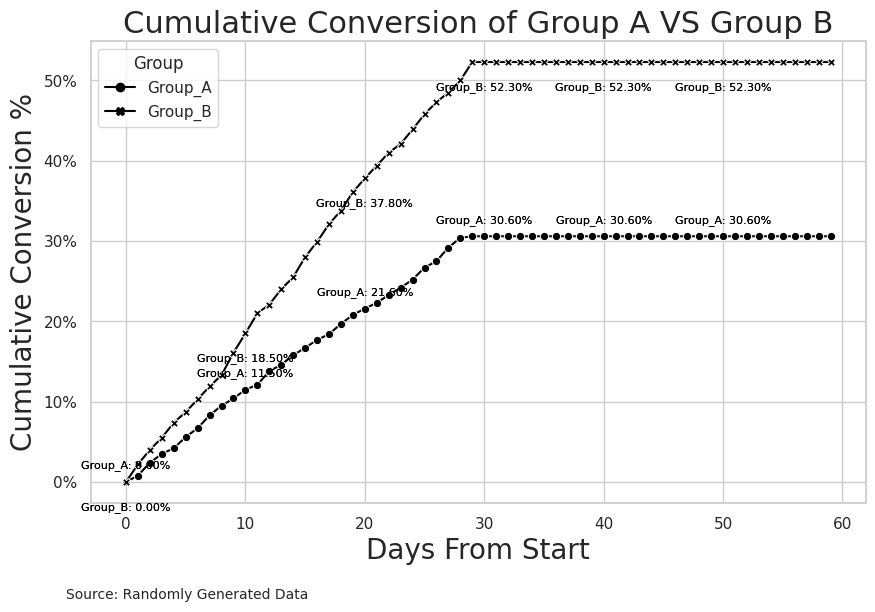

In [7]:
sns.set(style="whitegrid", font_scale=1)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6),frameon =False)

# Plot the line chart on the primary y-axis with black color and dots
line = sns.lineplot(data=fin_df, x="X", y="Y", hue="Group", palette={'Group_A': 'black', 'Group_B': 'black'}, markers=True, style="Group", dashes=False)

#Set x-axis label and title
ax.set_xlabel('Days From Start', fontsize=20)
ax.set_ylabel('Cumulative Conversion %', fontsize=20)
ax.set_title('Cumulative Conversion of Group A VS Group B', fontsize=22)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Add x-axis grid lines every 10 values
ax.xaxis.set_major_locator(MultipleLocator(10))

# Add annotations for 'Group_A' and 'Group_B' every 10 ticks
for index, value in enumerate(fin_df['X']):
    if index % 10 == 0:
        group_a_value = fin_df.loc[(fin_df['X'] == value) & (fin_df['Group'] == 'Group_A'), 'Y'].values[0]
        group_b_value = fin_df.loc[(fin_df['X'] == value) & (fin_df['Group'] == 'Group_B'), 'Y'].values[0]
        
        # Format the values as percentages
        group_a_percentage = group_a_value * 100
        group_b_percentage = group_b_value * 100

        # Annotate with formatted percentages
        ax.annotate(f'Group_A: {group_a_percentage:.2f}%', (value, group_a_value), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='black')
        ax.annotate(f'Group_B: {group_b_percentage:.2f}%', (value, group_b_value), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=8, color='black')

# Adding a footnote below the x-axis
footnote_text = "Source: Randomly Generated Data"
plt.figtext(0.1, -0.05, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

# Show the plot
plt.savefig("graph2.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

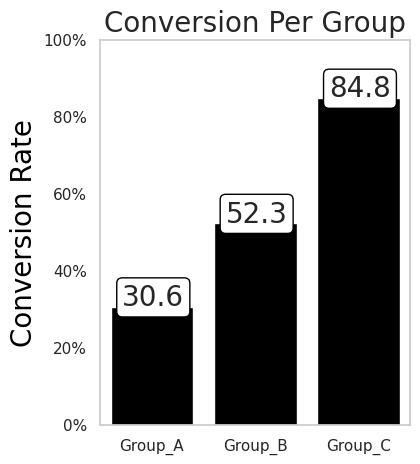

In [8]:
final_df = df

# Axis 1
y1 = final_df[['Group','IsConversion']].groupby('Group').mean()*100

x = y1.index.tolist()
y1 = y1['IsConversion']

sns.set(style="whitegrid", font_scale=1)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(4, 5),frameon =False)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(x=x, y=y1, ax=ax1, color='darkorange')
bar = sns.barplot(x=x, y=y1, ax=ax1, color='black')
ax1.set_ylabel('Conversion Rate', color='black', fontsize=20)
ax1.set_ylim([0, 100])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# Add values on top of the bars
for i, v in enumerate(y1):
    ax1.annotate(f'{v:,.1f}', xy=(i, v), xytext=(1, 1), ha='center', textcoords='offset points',bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white'),fontsize=20) 

plt.xticks(rotation=0) 

# Set x-axis label and title
ax1.set_xlabel('', fontsize=20)
ax1.set_title('Conversion Per Group', fontsize=20)

# Disable the background grid lines
ax1.grid(False)
ax1.grid(False)

# Show the plot
plt.savefig("overall.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()


In [9]:
def create_sequence(num_ones, total_length):
    num_zeros = total_length - num_ones
    ones = repeat(1, num_ones)
    zeros = repeat(0, num_zeros)
    
    sequence = list(chain(ones, zeros))
    return sequence

In [10]:
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    
    scale_one = con_conv * (1-con_conv) * (1/ con_size)
    scale_two = test_conv * (1-test_conv) * (1/ test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale = scale_val)  
    return p_value

In [11]:
def get_ci(lift, alpha, sd):
    val = abs(stats.norm.ppf((1-alpha)/2))
    
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    
    return (lwr_bnd, upr_bnd)

In [12]:
#Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. 
#                            This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
#Alpha value (α) — The critical value we set earlier to 0.05
#Effect size — How big of a difference we expect there to be between the conversion rates

required_n = sms.NormalIndPower().solve_power(
    sms.proportion_effectsize(0.10, 0.09), 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

13488


In [13]:
con_size = 82000
test_size = 82000

con_conv = 1000/con_size
test_conv = 1050/test_size

con_conv = 0.01
test_conv = 0.011

get_pvalue(con_conv, test_conv, con_size, test_size)

0.04697477066748545

In [14]:
con_size = 50000
test_size = 50000

con_conv = 1000/con_size
test_conv = 1100/test_size

lift_mean = test_conv - con_conv
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - con_conv) * con_conv / con_size
lift_sd = lift_variance**0.5
get_ci(lift_mean, 0.95, lift_sd)

(0.00022266817464121282, 0.003777331825358784)

In [15]:
n_con = 50000
n_treat = 50000

suc_con = 1000
suc_treat = 1088

successes = [suc_con, suc_treat]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Conv Con: {suc_con/n_con:.4f}')
print(f'Conv Treat: {suc_treat/n_treat:.4f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.4f}, {upper_con:.4f}]')
print(f'ci 95% for treatment group: [{lower_treat:.4f}, {upper_treat:.4f}]')

Conv Con: 0.0200
Conv Treat: 0.0218
z statistic: -1.95
p-value: 0.052
ci 95% for control group: [0.0188, 0.0212]
ci 95% for treatment group: [0.0205, 0.0230]


Reject null hypothesis: There is a significant difference.
p-value 0.04907913085485977
Confidence interval for A: (0.018772826464560546, 0.021227173535439455)
Confidence interval for B: (0.020500544599091685, 0.023059455400908316)


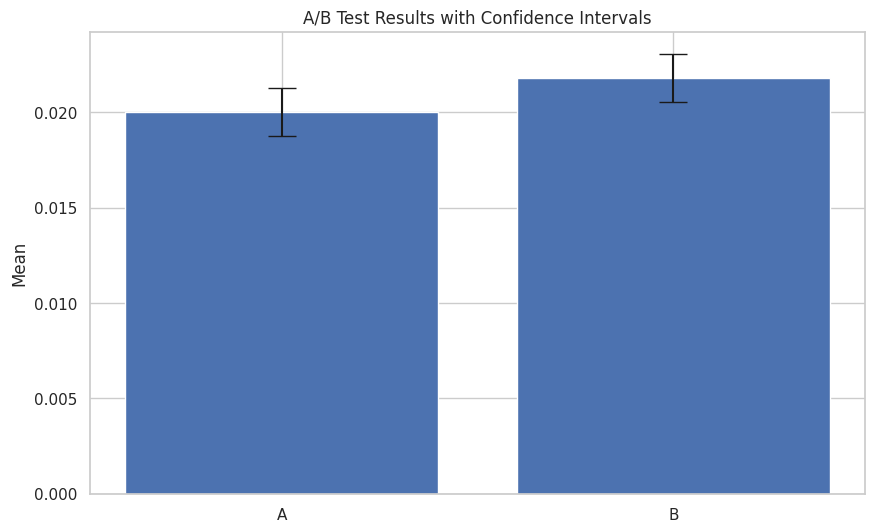

In [16]:
data_a = np.array(create_sequence(1000, 50000))  
data_b = np.array(create_sequence(1089, 50000))  

t_stat, p_value = stats.ttest_ind(data_a, data_b)
alpha = 0.05  # Significance level

if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference.")
    print("p-value",p_value)
else:
    print("Fail to reject null hypothesis: No significant difference.")
    print("p-value",p_value)
    
confidence_level = 0.95

# Calculate means and standard errors
mean_a = np.mean(data_a)
mean_b = np.mean(data_b)
std_a = np.std(data_a, ddof=1)  # Use ddof=1 for sample standard deviation
std_b = np.std(data_b, ddof=1)
n_a = len(data_a)
n_b = len(data_b)

# Calculate standard errors
se_a = std_a / np.sqrt(n_a)
se_b = std_b / np.sqrt(n_b)

# Calculate confidence intervals
ci_a = stats.t.interval(confidence_level, df=n_a - 1, loc=mean_a, scale=se_a)
ci_b = stats.t.interval(confidence_level, df=n_b - 1, loc=mean_b, scale=se_b)

print(f"Confidence interval for A: {ci_a}")
print(f"Confidence interval for B: {ci_b}")

plt.figure(figsize=(10, 6))
plt.bar(['A', 'B'], [mean_a, mean_b], yerr=[(mean_a - ci_a[0], ci_a[1] - mean_a), (mean_b - ci_b[0], ci_b[1] - mean_b)], capsize=10)
plt.ylabel('Mean')
plt.title('A/B Test Results with Confidence Intervals')
plt.show()